### Figure generation notebook for MERFISH single cell quality control and comparisons to MACA

###  To do:

In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
from scipy.sparse import csr_matrix
from scipy.stats import ks_2samp
import anndata
import scanpy
import string
import seaborn as sns
import h5py
import tifffile
import fs
from fs import open_fs
from matplotlib_scalebar.scalebar import ScaleBar
from merlin.core import dataset
from tqdm import tqdm

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [102]:
# Load raw MERFISH results
# Define the path of the analyzed data

dataPath = '../../../MERlin_Analysis'

# Define the experiment

experimentName = 'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021'

# Load MERlin tasks
d_set = dataset.MERFISHDataSet(experimentName)


# Decoded transcripts
detectedTranscripts = pd.read_csv(os.path.join(
    dataPath, experimentName, 'ExportBarcodes', 'region_0', 'barcodes.csv'))

# Cell segmentation metadata
cellMetadata = pd.read_csv(os.path.join(
    dataPath, experimentName, 'ExportCellMetadata', 'region_0','feature_metadata_augmented.csv'), index_col=0)

# Counts per segmented cell
cellByGene = pd.read_csv(os.path.join(
    dataPath, experimentName, 'ExportPartitionedBarcodes', 'region_0', 'barcodes_per_feature.csv'), index_col=0)

# Transformation matrix
# transformation_matrix = np.loadtxt(
#     os.path.join(dataPath, experimentName, "BlendMosaic", "region_0", 'micron_to_mosaic_pixel_transform.csv'))
# size_of_one_pixel = 1 / transformation_matrix[0, 0]

# Filtered single cell counts


print('Dataset loaded.')

Dataset loaded.


In [126]:
# Load postprocessed MERFISH and MACA results
# We should run SI fig 2 first to determine the count threshold cutoff, and then create
# the filtered .h5ad object to use here eventually.

# Define the path of the analyzed MERFISH data
dataPathPost = '../../../MERlin_Analysis/ProcessedResults'

# Define the experiment
experimentNamePost = 'MsLiver_Cellbound_VZG116_V1_JH_09-18-2021'
prefixCounts = 'RawCounts'
prefixCountsFilter = 'FilteredCounts'
suffixCounts = '_RawSingleCellCounts.h5ad'
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

# Load the MERlin results

# Raw counts per segmented cell
VizgenCounts = anndata.read_h5ad(os.path.join(dataPathPost, prefixCounts, experimentNamePost + suffixCounts))

# Filtered counts per segmented cell
VizgenCountsFilter = anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                    experimentNamePost + suffixCountsFilter))

# Get filtering criteria
QCFilter = VizgenCountsFilter.uns['QC_filter']
min_volume = QCFilter['min_cell_volume']
max_volume = QCFilter['max_cell_volume']
min_counts = QCFilter['min_transcript_count']
min_dapi = QCFilter['min_dapi_score']

# Convert all gene names to upper case
VizgenCounts.var.index = VizgenCounts.var.index.str.upper()

# Load raw MACA data (10X)
dataPathMACA = '/mnt/ibm_lg/angela/'
experimentMACA10X = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'
MACA_10X_h5ad = anndata.read_h5ad(os.path.join(dataPathMACA, experimentMACA10X))

# Load raw MACA data (SmartSeq)
experimentMACASmartSeq = 'tabula-muris-senis-facs-official-raw-obj.h5ad'
MACA_SmartSeq_h5ad = anndata.read_h5ad(os.path.join(dataPathMACA, experimentMACASmartSeq))

# Select only the tissue-specific cells from the raw datasets
MACAliver_10X_h5ad = MACA_10X_h5ad[MACA_10X_h5ad.obs['tissue'] == 'Liver']
MACAliver_SmartSeq_h5ad = MACA_SmartSeq_h5ad[MACA_SmartSeq_h5ad.obs['tissue'] == 'Liver']


# Convert genes to lower case
VizgenCounts.var.index = VizgenCounts.var.index.str.lower()
VizgenCountsFilter.var.index = VizgenCountsFilter.var.index.str.lower()
MACAliver_10X_h5ad.var.index = MACAliver_10X_h5ad.var.index.str.lower()
MACAliver_SmartSeq_h5ad.var.index = MACAliver_SmartSeq_h5ad.var.index.str.lower()

# Select shared gene panel genes only
genes_Vizgen = VizgenCounts.var.index
genes_VizgenFilter = VizgenCountsFilter.var.index
genes_10X = MACAliver_10X_h5ad.var.index
genes_SmartSeq = MACAliver_SmartSeq_h5ad.var.index
genes_shared = genes_Vizgen.intersection(genes_10X) # List of shared genes

VizgenCounts = VizgenCounts[:, genes_Vizgen.isin(genes_shared)]
VizgenCountsFilter = VizgenCountsFilter[:, genes_VizgenFilter.isin(genes_shared)]
MACAliver_10X = MACAliver_10X_h5ad[:, genes_10X.isin(genes_shared)]
MACAliver_SmartSeq = MACAliver_SmartSeq_h5ad[:, genes_SmartSeq.isin(genes_shared)]

print('Postprocessed results loaded.')

SyntaxError: invalid syntax (1109164619.py, line 28)

### Panel A: Sample segmentation for a dataset

In [117]:
# Load DAPI mosaic and transformation matrix
zInd = 3
z_stack = ['z0','z1','z2','z3','z4','z5','z6']
dapi_mosaic = tifffile.TiffFile(os.path.join(
    dataPath, experimentName, "BlendMosaic", "region_0" , 'mosaic_DAPI_' + z_stack[zInd] + '.tif')).asarray()
transformation_matrix = np.loadtxt(
    os.path.join(dataPath, experimentName, "BlendMosaic", "region_0", 'micron_to_mosaic_pixel_transform.csv'))

print('Mosaic loaded.')

Mosaic loaded.


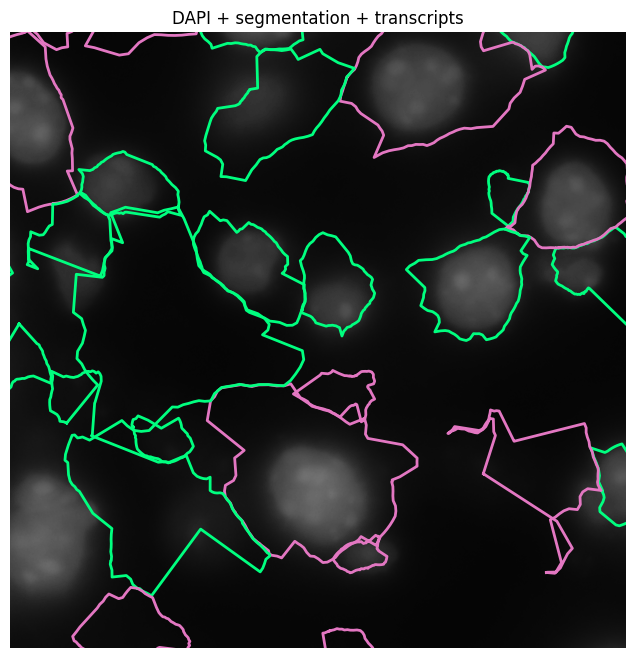

In [118]:
# Plot the image overlay using the DAPI mosaic

fov = 33
minX = 200
maxX = 1000
minY = 100
maxY = 900

cell_boundaries = h5py.File(os.path.join(dataPath, experimentName, \
                                         'RefineCellDatabases', 'features', \
                                         'feature_data_%i.hdf5' % fov), 'r')

size_of_one_pixel = 1 / transformation_matrix[0,0]

# Get the boundary segmentation coordinates and filtering acceptance status
current_cells = []
current_cells_filter = []
for i in cellMetadata[cellMetadata['fov'] == fov].index:
    if i in cell_boundaries['featuredata'] and 'p_0' in cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]:
        # Get the boundary for this cell
        temp = np.array(cell_boundaries['featuredata'][i]['zIndex_%i' % zInd]['p_0']['coordinates'][0])
        boundary_polygon = np.ones((temp.shape[0], temp.shape[1]+1))
        boundary_polygon[:, :-1] = temp
        transformed_boundary = np.matmul(transformation_matrix, np.transpose(boundary_polygon))[:-1]
        current_cells.append(transformed_boundary)
        
        # Save the filtering status for this cell
        if cellMetadata.loc[i,'volume'] < min_volume or cellMetadata.loc[i,'volume'] > max_volume \
        or cellByGene.loc[i,:].sum() < min_counts or cellMetadata.loc[i,'median average DAPI'] < min_dapi:
            current_cells_filter.append(0)
        else:
            current_cells_filter.append(1)
            
min_coord = np.min([np.min(x, axis=1) for x in current_cells], axis=0).astype(int)
max_coord = np.max([np.max(x, axis=1) for x in current_cells], axis=0).astype(int)   

# Get transcript positions
active_transcripts = detectedTranscripts[detectedTranscripts['fov'] == fov].copy()
temp = active_transcripts[['global_y', 'global_x']].values
transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
transcript_positions[:, :-1] = temp
transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
active_transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
active_transcripts.loc[:,'local_y'] = transformed_positions[1, :]

# Plot DAPI + transcripts + boundaries
fig, ax = plt.subplots(figsize=(8,8))

ax.imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], 
          vmin=0, vmax=20000, cmap=plt.cm.gray)

ax.scatter(active_transcripts['local_y'] - min_coord[0], active_transcripts['local_x'] - min_coord[1],  
                c='tab:blue', cmap='Accent', s=1)

for i in range(len(current_cells)): # Plot cell boundaries
    if current_cells_filter[i] == 0:
        ax.plot(current_cells[i][0] - min_coord[0], current_cells[i][1] - min_coord[1],
                color='tab:pink', linestyle='-', linewidth=2)
    elif current_cells_filter[i] == 1:
        ax.plot(current_cells[i][0] - min_coord[0], current_cells[i][1] - min_coord[1],
                color='springgreen', linestyle='-', linewidth=2)
ax.set_xlim(minX, maxX)
ax.set_ylim(minY, maxY)

ax.set_title('DAPI + segmentation + transcripts')
ax.axis('off')

fig

### Panel B and C: Histogram of cell volumes and counts

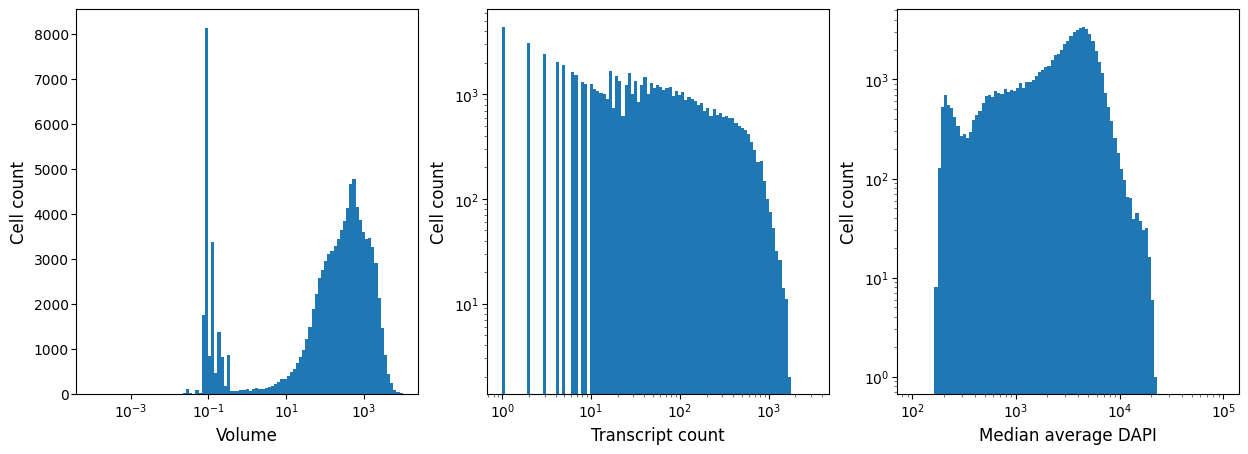

In [119]:
# Quality control and filtering

# Plot single cell quality control metrics

fig = plt.figure(figsize=(15, 5))

# Cell count by volume
plt.subplot(1,3,1)
bins = np.logspace(-4,4,100)
plt.hist(VizgenCounts.obs['volume'], bins=bins)
plt.xlabel('Volume')
plt.ylabel('Cell count')
plt.xscale('log')

# Transcript count by cell
plt.subplot(1,3,2)
bins = np.logspace(0,3.5,100)
plt.hist(VizgenCounts.obs['barcodeCount'], bins=bins)
plt.xlabel('Transcript count')
plt.ylabel('Cell count')
plt.xscale('log')
plt.yscale('log')

# Average median DAPI intensity by cell
plt.subplot(1,3,3)
bins = np.logspace(2,5,100)
plt.hist(VizgenCounts.obs['median average DAPI'], bins=bins)
plt.xlabel('Median average DAPI')
plt.ylabel('Cell count')
plt.xscale('log')
plt.yscale('log')

fig

In [120]:
# How many cells were filtered out via quality control?
N_raw = len(VizgenCounts)
N_filter = len(VizgenCountsFilter)
print(str(N_filter) + ' cells remaining out of ' + str(N_raw) + ' total after filtering.')

32846 cells remaining out of 104158 total after filtering.


### Panel D/E: Distribution of cell counts across technologies

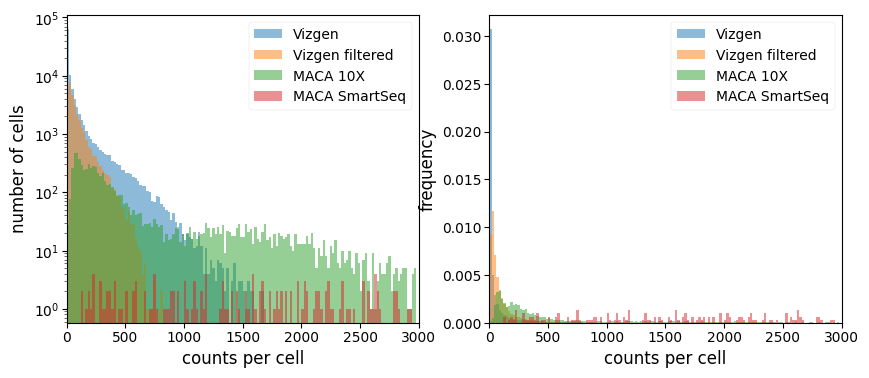

In [121]:
bins = np.arange(0,3000,20)

fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(VizgenCounts.X.sum(axis=1),alpha=0.5,bins=bins,label='Vizgen')
plt.hist(VizgenCountsFilter.X.sum(axis=1),alpha=0.5,bins=bins,label='Vizgen filtered')
plt.hist(MACAliver_10X.X.sum(axis=1),alpha=0.5,bins=bins,label='MACA 10X')
plt.hist(MACAliver_SmartSeq.X.sum(axis=1),alpha=0.5,bins=bins,label='MACA SmartSeq')
plt.xlabel('counts per cell')
plt.ylabel('number of cells')
plt.xlim((0,3000))
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
plt.hist(VizgenCounts.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen')
plt.hist(VizgenCountsFilter.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen filtered')
plt.hist(MACAliver_10X.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA 10X')
plt.hist(MACAliver_SmartSeq.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA SmartSeq')
plt.xlabel('counts per cell')
plt.ylabel('frequency')
plt.xlim((0,3000))
plt.legend()

fig

### Panel F: Distribution of dropout rates

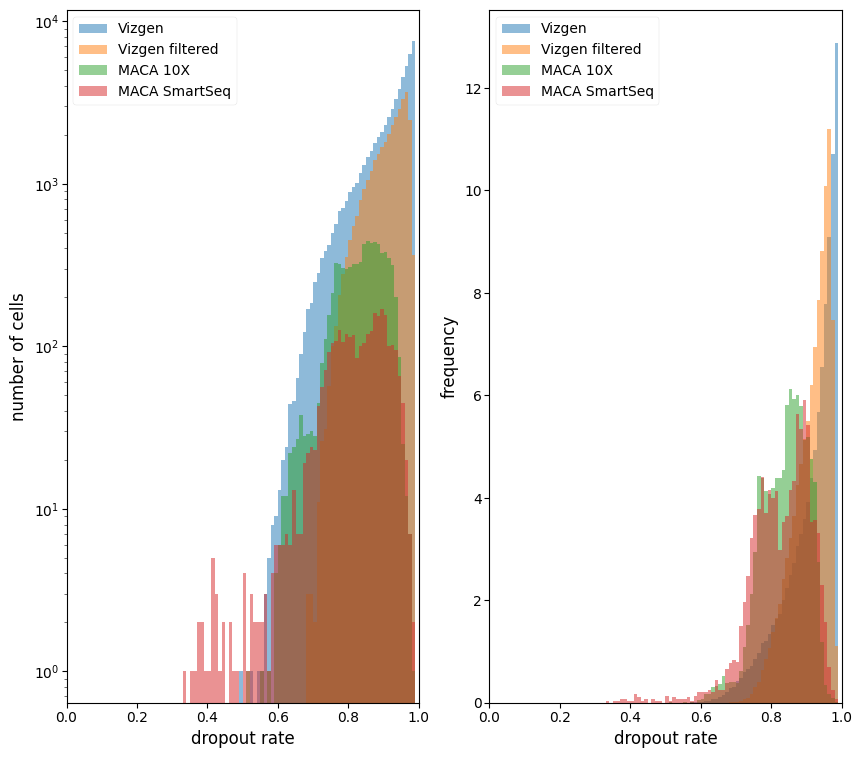

In [122]:
# Number of genes that have zero count for each cell divided by total number of genes in panel

VizgenDropoutFrac = 1 - np.count_nonzero(VizgenCounts.X, axis=1) / VizgenCounts.shape[1]
VizgenFilterDropoutFrac = 1 - np.count_nonzero(VizgenCountsFilter.X, axis=1) / VizgenCounts.shape[1]
MACADropoutFrac_10X = 1 - np.count_nonzero(MACAliver_10X.X.toarray(), axis=1) / VizgenCounts.shape[1]
MACADropoutFrac_SmartSeq = 1 - np.count_nonzero(MACAliver_SmartSeq.X.toarray(), axis=1) / VizgenCounts.shape[1]

# Plot the dropout rate
bins = np.arange(0,1,0.01)
fig = plt.figure()

plt.subplot(1,2,1)
plt.hist(VizgenDropoutFrac,alpha=0.5,density=False,bins=bins,label='Vizgen')
plt.hist(VizgenFilterDropoutFrac,alpha=0.5,density=False,bins=bins,label='Vizgen filtered')
plt.hist(MACADropoutFrac_10X,alpha=0.5,density=False,bins=bins,label='MACA 10X')
plt.hist(MACADropoutFrac_SmartSeq,alpha=0.5,density=False,bins=bins,label='MACA SmartSeq')
plt.xlabel('dropout rate')
plt.ylabel('number of cells')
plt.yscale('log')
plt.xlim((0,1))
plt.legend()

plt.subplot(1,2,2)
plt.hist(VizgenDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen')
plt.hist(VizgenFilterDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen filtered')
plt.hist(MACADropoutFrac_10X,alpha=0.5,density=True,bins=bins,label='MACA 10X')
plt.hist(MACADropoutFrac_SmartSeq,alpha=0.5,density=True,bins=bins,label='MACA SmartSeq')
plt.xlabel('dropout rate')
plt.ylabel('frequency')
plt.xlim((0,1))
plt.legend()

fig

### Number of cells containing the rarest 10 genes

/tmp/ipykernel_1684401/747365862.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(subset.index, rotation=45)
/tmp/ipykernel_1684401/747365862.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(subset.index, rotation=45)


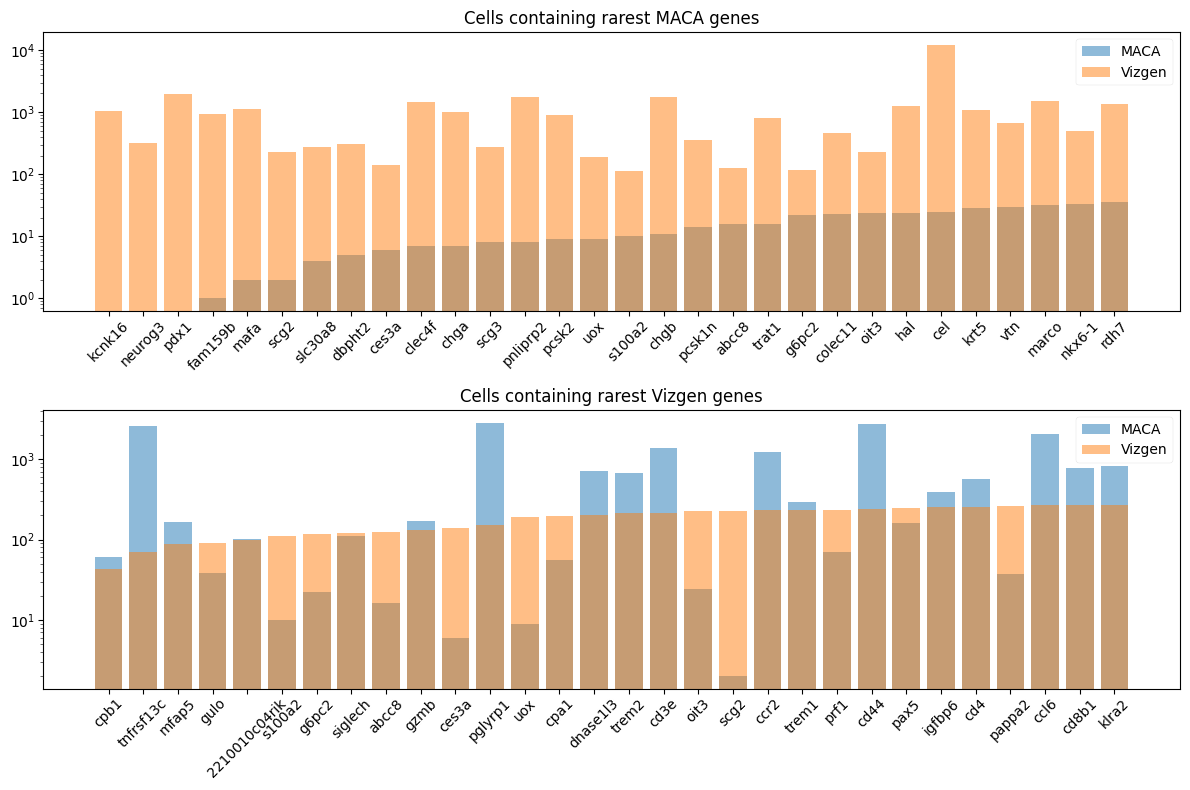

In [56]:
# Look at the 10 rarest genes from MACA 10X liver dataset
BinaryMACAliver_10XCounts = MACAliver_10X.copy().to_df()
BinaryMACAliver_10XCounts.columns = BinaryMACAliver_10XCounts.columns.str.lower() # Use lower case gene names
BinaryMACAliver_10XCounts[BinaryMACAliver_10XCounts > 0] = 1
BinaryMACAliver_10XCounts[BinaryMACAliver_10XCounts == 0] = 0
NumCellsDetected_MACAliver_10X = BinaryMACAliver_10XCounts.sum(axis=0)
#NumCellsDetected_MACAliver_10X = NumCellsDetected_MACAliver_10X.sort_values()

BinaryVizgenCounts = VizgenCountsFilter.copy().to_df()
BinaryVizgenCounts.columns = BinaryVizgenCounts.columns.str.lower() # Use lower case gene names
BinaryVizgenCounts[BinaryVizgenCounts > 0] = 1
BinaryVizgenCounts[BinaryVizgenCounts == 0] = 0
NumCellsDetected_Vizgen = BinaryVizgenCounts.sum(axis=0)
#NumCellsDetected_Vizgen = NumCellsDetected_Vizgen.sort_values()

# Merge the dataframes
NumCellsDetected = pd.DataFrame({'MACA' : NumCellsDetected_MACAliver_10X, 'Vizgen' : NumCellsDetected_Vizgen})

# Plot
subset = NumCellsDetected.sort_values(by='MACA')[0:30] # Subset of genes to examine for MACA rare genes
fig, ax = plt.subplots(2,1, figsize=(12,8))

ax[0].bar(subset.index, subset['MACA'], alpha=0.5, label='MACA')
ax[0].bar(subset.index, subset['Vizgen'], alpha=0.5, label='Vizgen')
ax[0].set_title('Cells containing rarest MACA genes')
ax[0].set_xticklabels(subset.index, rotation=45)
ax[0].set_yscale('log')
ax[0].legend()

subset = NumCellsDetected.sort_values(by='Vizgen')[0:30] # Subset of genes to examine for Vizgen rare genes

ax[1].bar(subset.index, subset['MACA'], alpha=0.5, label='MACA')
ax[1].bar(subset.index, subset['Vizgen'], alpha=0.5, label='Vizgen')
ax[1].set_title('Cells containing rarest Vizgen genes')
ax[1].set_xticklabels(subset.index, rotation=45)
ax[1].set_yscale('log')
ax[1].legend()

fig.tight_layout()

fig

### Look at how many transcripts are retained from bulk -> single cell -> filtered

In [107]:
bulkCounts = pd.DataFrame(index=detectedTranscripts['gene'].unique()) # Setup bulk dataframe
bulkCounts = bulkCounts[~bulkCounts.index.str.contains('Blank')]
bulkCounts['count'] = 0 # Initialize counts
for i in tqdm(range(len(bulkCounts.index))):
    bulkCounts.loc[bulkCounts.index[i],'count'] = np.sum(detectedTranscripts['gene'] == bulkCounts.index[i])
    


100%|█████████████████████████████████████████| 307/307 [03:28<00:00,  1.47it/s]


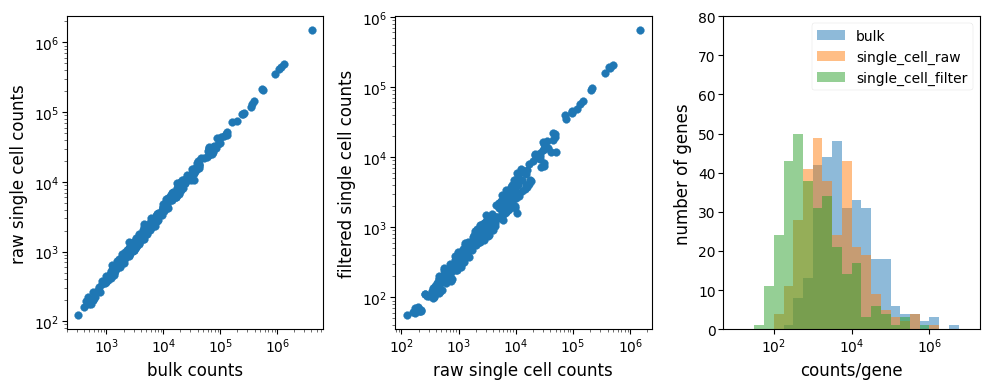

In [334]:
singleCellCounts = VizgenCounts.to_df().sum(axis=0)
singleCellCountsFilter = VizgenCountsFilter.to_df().sum(axis=0)

# Make combined dataframe
combinedCounts = bulkCounts.copy()
combinedCounts = combinedCounts.rename(columns={'count':'bulk'})
combinedCounts['single_cell_raw'] = singleCellCounts
combinedCounts['single_cell_filter'] = singleCellCountsFilter

# Plot
fig, ax = plt.subplots(1,3,figsize=(10,4))

ax[0].scatter(combinedCounts['bulk'], combinedCounts['single_cell_raw'])
ax[0].set_xlabel('bulk counts')
ax[0].set_ylabel('raw single cell counts')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].scatter(combinedCounts['single_cell_raw'], combinedCounts['single_cell_filter'])
ax[1].set_xlabel('raw single cell counts')
ax[1].set_ylabel('filtered single cell counts')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

bins = np.logspace(1,7,25)
combinedCounts.plot.hist(combinedCounts, bins=bins, alpha=0.5, ax=ax[2])
ax[2].set_xscale('log')
ax[2].set_xlabel('counts/gene')
ax[2].set_ylabel('number of genes')
ax[2].set_ylim((0,80))

fig.tight_layout()

fig

### Look at single cell counts for particular genes for Vizgen vs. MACA

In [123]:
# Let's look at the 4 genes with the largest total single-cell counts in MACA
# and look at their counts/cell distributions for cells with high or with medium total counts
MACAliver_10X_counts = MACAliver_10X.to_df().sum(axis=0)

# Sort by count number descending
MACAliver_10X_counts = MACAliver_10X_counts.sort_values(ascending=False)
largest_n = MACAliver_10X_counts.index[0:4] # 4 most abundant genes in MACA
medium_n = MACAliver_10X_counts.index[150:154] # 4 middle-ish abundant genes in MACA

# Split the cells in each dataset into < and > 1000 total counts/cell
count_threshold = 100
MACAliver_10X_bottomcells = MACAliver_10X[MACAliver_10X.to_df().sum(axis=1) < count_threshold,:]
MACAliver_10X_topcells = MACAliver_10X[MACAliver_10X.to_df().sum(axis=1) >= count_threshold,:]
Vizgen_bottomcells = VizgenCountsFilter[VizgenCountsFilter.to_df().sum(axis=1) < count_threshold,:]
Vizgen_topcells = VizgenCountsFilter[VizgenCountsFilter.to_df().sum(axis=1) >= count_threshold,:]


# Plot the Vizgen vs MACA histograms across cells for these genes
fig, ax = plt.subplots(2,4,figsize=(10,6))
bins = np.logspace(0,3,10)

# Most abundant genes in highest count cells
for i, gene in enumerate(largest_n):
    ax[0,i].hist(MACAliver_10X_topcells[:,gene].X.toarray(), alpha=0.5, density=False, bins=bins, label='MACA')
    ax[0,i].hist(Vizgen_topcells[:,gene.upper()].X.toarray(), alpha=0.5, density=False, bins=bins, label='Vizgen')
    ax[0,i].set_title(gene)
    ax[0,i].set_xlabel('counts/cell')
    ax[0,i].set_ylabel('cell count')
    ax[0,i].set_xscale('log')
    ax[0,i].legend()
    
# Most abundant genes in lowest count cells
for i, gene in enumerate(largest_n):
    ax[1,i].hist(MACAliver_10X_bottomcells[:,gene].X.toarray(), alpha=0.5, density=False, bins=bins, label='MACA')
    ax[1,i].hist(Vizgen_bottomcells[:,gene.upper()].X.toarray(), alpha=0.5, density=False, bins=bins, label='Vizgen')
    ax[1,i].set_title(gene)
    ax[1,i].set_xlabel('counts/cell')
    ax[1,i].set_ylabel('cell count')
    ax[1,i].set_xscale('log')
    ax[1,i].legend()
    
fig.tight_layout()
fig

KeyError: 'H2-AB1'

In [451]:
# Compare distribution similarity vs. total cell count for some genes
# Bin cells by total count, then calculate KS D statistic between all genes and take the average + SD

bins_count = np.logspace(1.5,3.5,15)
MACA_bin = []
Vizgen_bin = []

print('Creating binned AnnData objects.')
for i in tqdm(range(len(bins_count)-1)):
    MACA_bin.append(MACAliver_10X[np.logical_and(
        MACAliver_10X.to_df().sum(axis=1) >= bins_count[i],
        MACAliver_10X.to_df().sum(axis=1) < bins_count[i+1]),:])
    Vizgen_bin.append(VizgenCountsFilter[np.logical_and(
        VizgenCountsFilter.to_df().sum(axis=1) >= bins_count[i],
        VizgenCountsFilter.to_df().sum(axis=1) < bins_count[i+1]),:])
print('AnnData objects binned.')

mean_KSD_bin = []
sd_KSD_bin = []
se_KSD_bin = []

# Calculate the KS statistic
print('Calculating KS distances.')
for i in tqdm(range(len(MACA_bin))):
    # Initialize array of KS distances as nans
    N_genes = VizgenCountsFilter.shape[1]
    KSD_gene = np.zeros(N_genes)
    KSD_gene[KSD_gene == 0] = np.nan
    for j in range(N_genes):
        gene = MACA_bin[i].var.index[j]
        a = np.squeeze(MACA_bin[i][:,gene].X.toarray())
        b = np.squeeze(Vizgen_bin[i][:,gene.upper()].X.toarray())
        
        # Only consider cells with nonzero reads
        a = a[a!=0]
        b = b[b!=0]
        
        if a.size > 0 and b.size > 0:
            KSD_gene[j] = ks_2samp(a,b)[0]
    mean_KSD_bin.append(np.nanmean(KSD_gene))
    sd_KSD_bin.append(np.nanstd(KSD_gene))
    se_KSD_bin.append(np.nanstd(KSD_gene) / np.sqrt(np.sum(~np.isnan(KSD_gene))))
    
print('KS distances calculated.')

Creating binned AnnData objects.


100%|███████████████████████████████████████████| 14/14 [00:09<00:00,  1.46it/s]


AnnData objects binned.
Calculating KS distances.


 14%|██████▎                                     | 2/14 [00:10<01:04,  5.41s/it]/tmp/ipykernel_3284/3269163412.py:40: RuntimeWarning: Mean of empty slice
  mean_KSD_bin.append(np.nanmean(KSD_gene))
/data01/jonathan.liu/miniconda3/envs/merlin_env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|███████████████████████████████████████████| 14/14 [02:11<00:00,  9.37s/it]

KS distances calculated.


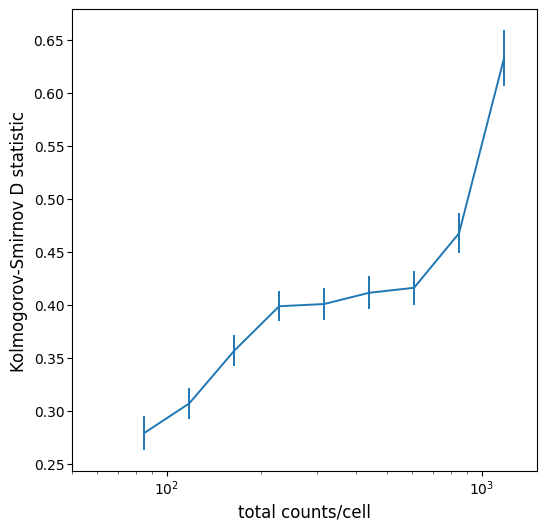

In [477]:
# Plot the mean and SD KS statistic as a function of binned total cell count
fig, ax = plt.subplots(figsize=(6,6))

ax.errorbar(bins_count[0:-1], mean_KSD_bin, yerr=se_KSD_bin)
ax.set_xlim((50,1500))
ax.set_xlabel('total counts/cell')
ax.set_ylabel('Kolmogorov-Smirnov D statistic')
ax.set_xscale('log')

fig

100%|█████████████████████████████████████████| 302/302 [01:56<00:00,  2.60it/s]


In [472]:
# Calculate the median count (ignoring zeros) for each gene between Vizgen and MACA
gene_median_MACA = MACAliver_10X.to_df().replace(0,np.nan).median(axis=0, skipna=True)
gene_median_MACA.index = gene_median_MACA.index.str.upper()
gene_median_Vizgen = VizgenCountsFilter.to_df().replace(0,np.nan).median(axis=0, skipna=True)

gene_median_combined = pd.DataFrame({'median_MACA': gene_median_MACA, 'median_Vizgen': gene_median_Vizgen})

# Also calculate the KS statistic for each gene without binning by total cell count
# Don't consider cells with zero counts
gene_median_combined['KS statistic'] = np.nan

for i in tqdm(range(N_genes)):
    gene = MACAliver_10X.var.index[i]
    MACA_gene = MACAliver_10X[:,gene].X.toarray()
    MACA_gene = MACA_gene[MACA_gene != 0]
    Vizgen_gene = VizgenCountsFilter[:,gene.upper()].X.toarray()
    Vizgen_gene = Vizgen_gene[Vizgen_gene != 0]
    
    if MACA_gene.size > 0 and Vizgen_gene.size > 0:
        gene_median_combined.loc[gene.upper(),'KS statistic'] = ks_2samp(MACA_gene, Vizgen_gene)[0]

fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].scatter(gene_median_combined['median_MACA'], gene_median_combined['median_Vizgen'])
ax[0].set_xlabel('median gene count MACA')
ax[0].set_ylabel('median gene count Vizgen')

# Plot the KS statistics between Vizgen and MACA for each gene
ax[1].scatter(gene_median_combined['median_MACA'], gene_median_combined['KS statistic'])
ax[1].set_xlabel('median gene count MACA')
ax[1].set_ylabel('Kolmogorov-Smirnov D statistic')
ax[1].set_xscale('log')

fig

100%|█████████████████████████████████████████| 302/302 [01:29<00:00,  3.36it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'set_xlabel'

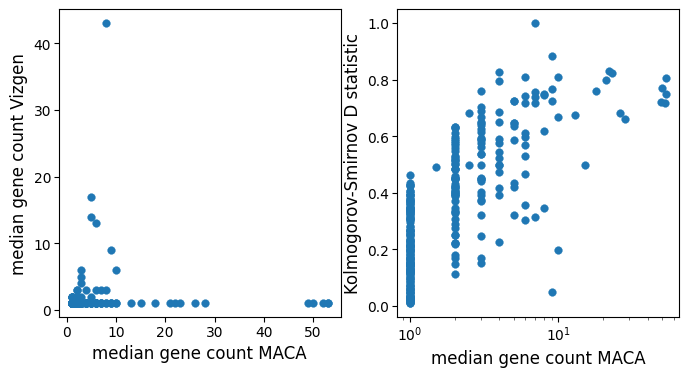

In [476]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].scatter(gene_median_combined['median_MACA'], gene_median_combined['median_Vizgen'])
ax[0].set_xlabel('median gene count MACA')
ax[0].set_ylabel('median gene count Vizgen')

# Plot the KS statistics between Vizgen and MACA for each gene
ax[1].scatter(gene_median_combined['median_MACA'], gene_median_combined['KS statistic'])
ax[1].set_xlabel('median gene count MACA')
ax[1].set_ylabel('Kolmogorov-Smirnov D statistic')
ax[1].set_xscale('log')

fig

### Plot combined figure

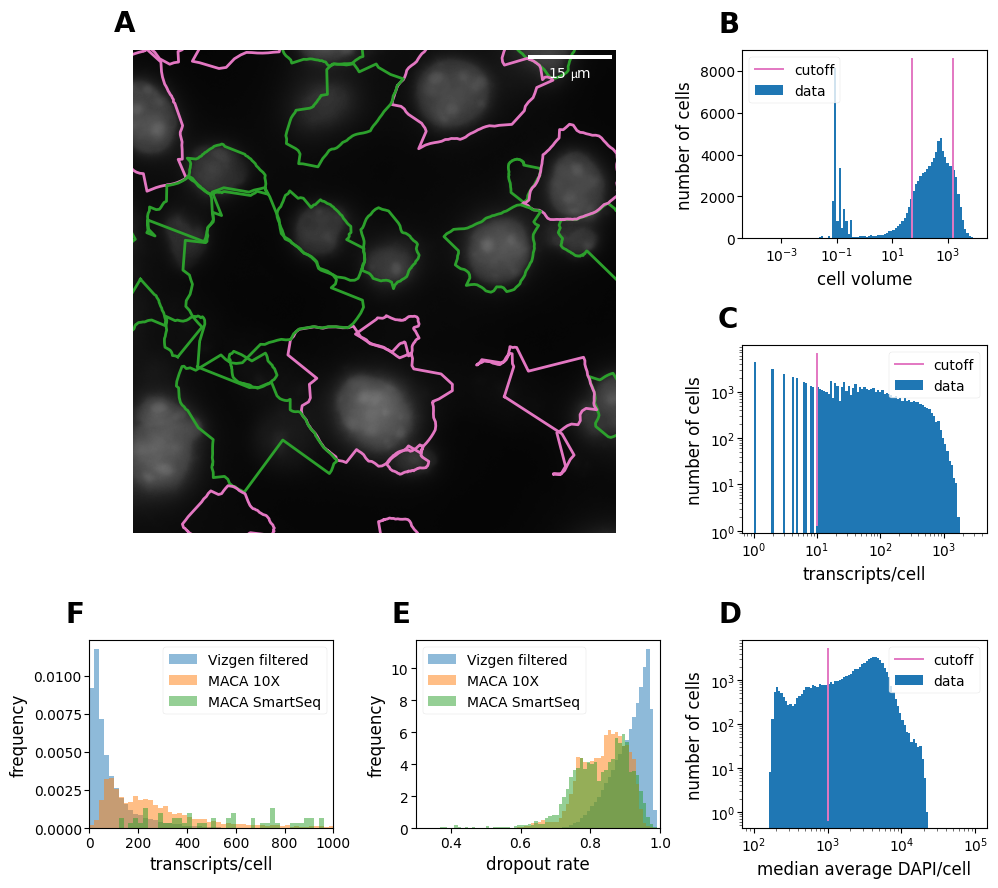

In [124]:
# Plot the whole figure
#fig, ax = plt.subplots(3,3, gridspec_kw={'width_ratios': []})
#f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]})

set_plotting_style()

fig, ax = plt.subplots(ncols=3, nrows=3) #Create 3x3 grid
gs = ax[0,0].get_gridspec() #Get gridspecs

# remove the underlying axes for Panel A
for i in [0,1]:
    for j in [0,1]:
        ax[i,j].remove()

axbig = fig.add_subplot(gs[0:2, 0:2])

# Panel A: image overlay
axbig.imshow(dapi_mosaic[min_coord[1]:max_coord[1], min_coord[0]:max_coord[0]], cmap='gray',
             vmin=0, vmax=20000, origin='lower') # Plot DAPI
axbig.scatter(active_transcripts['local_y'] - min_coord[0], active_transcripts['local_x'] - min_coord[1],  
                c='tab:blue', cmap='Accent', s=1)
for i in range(len(current_cells)): # Plot cell boundaries
    if current_cells_filter[i] == 0:
        axbig.plot(current_cells[i][0] - min_coord[0], current_cells[i][1] - min_coord[1],
                   color='tab:pink', linestyle='-', linewidth=2)
    elif current_cells_filter[i] == 1:
        axbig.plot(current_cells[i][0] - min_coord[0], current_cells[i][1] - min_coord[1],
                   color='tab:green', linestyle='-', linewidth=2)
axbig.set_xlim(minX, maxX)
axbig.set_ylim(minY, maxY)

axbig.axis('off')
scalebar = ScaleBar(size_of_one_pixel, "um", color='w', box_color='w', box_alpha=0)
axbig.add_artist(scalebar)

# Panel B: Vizgen histogram of cell volumes
bins = np.logspace(-4,4,100)
ax[0,2].hist(VizgenCounts.obs.volume,bins=bins, label='data')
ax[0,2].set_xlabel('cell volume')
ax[0,2].set_ylabel('number of cells')
ax[0,2].set_xscale('log')
ylim = ax[0,2].get_ylim()
ax[0,2].plot([min_volume, min_volume],ylim, '-', color='tab:pink', label='cutoff')
ax[0,2].plot([max_volume, max_volume],ylim, '-', color='tab:pink')
ax[0,2].legend()

# Panel C: Vizgen histogram of cell counts
bins = np.logspace(0,3.5,100)
ax[1,2].hist(VizgenCounts.obs.barcodeCount,bins=bins, label='data')
ax[1,2].set_xlabel('transcripts/cell')
ax[1,2].set_ylabel('number of cells')
ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')
ax[1,2].plot([min_counts, min_counts], ax[1,2].get_ylim(), '-', color='tab:pink', label='cutoff')
ax[1,2].legend()

# Panel D: TODO Vizgen histogram of average DAPI intensities
bins = np.logspace(2,5,100)
ax[2,2].hist(VizgenCounts.obs['median average DAPI'],bins=bins, label='data')
ax[2,2].set_xlabel('median average DAPI/cell')
ax[2,2].set_ylabel('number of cells')
ax[2,2].set_xscale('log')
ax[2,2].set_yscale('log')
ax[2,2].plot([min_dapi, min_dapi], ax[2,2].get_ylim(), '-', color='tab:pink', label='cutoff')
ax[2,2].legend()

# Panel F: Comparison histogram of cell counts
bins = np.arange(0,3000,20)
#ax[2,0].hist(VizgenCounts.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen')
ax[2,0].hist(VizgenCountsFilter.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen filtered')
ax[2,0].hist(MACAliver_10X.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA 10X')
ax[2,0].hist(MACAliver_SmartSeq.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA SmartSeq')
ax[2,0].set_xlabel('transcripts/cell')
ax[2,0].set_ylabel('frequency')
ax[2,0].set_xlim((0,1000))
#ax[2,0].set_yscale('log')
ax[2,0].legend()

# Comparison histogram of cell counts by frequency (probably don't need this)
# ax[2,1].hist(VizgenCounts.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen')
# ax[2,1].hist(VizgenCountsFilter.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='Vizgen filtered')
# ax[2,1].hist(MACAliver_10X.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA 10X')
# ax[2,1].hist(MACAliver_SmartSeq.X.sum(axis=1),alpha=0.5,density=True,bins=bins,label='MACA SmartSeq')
# ax[2,1].set_xlabel('counts per cell')
# ax[2,1].set_ylabel('frequency')
# ax[2,1].set_xlim((0,3000))
# ax[2,1].legend()

# Panel E: Comparison histogram of dropout rates
bins = np.arange(0,1,0.01)
#ax[2,1].hist(VizgenDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen')
ax[2,1].hist(VizgenFilterDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen filtered')
ax[2,1].hist(MACADropoutFrac_10X,alpha=0.5,density=True,bins=bins,label='MACA 10X')
ax[2,1].hist(MACADropoutFrac_SmartSeq,alpha=0.5,density=True,bins=bins,label='MACA SmartSeq')
ax[2,1].set_xlabel('dropout rate')
ax[2,1].set_ylabel('frequency')
ax[2,1].set_xlim((0.3,1))
ax[2,1].legend()

# Label subpanels
axes = [axbig, ax[0,2], ax[1,2], ax[2,2], ax[2,1], ax[2,0]]
for n, ax in enumerate(axes):
    if n == 0:
        ax.text(-0.04, 1.04, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
    else:
        ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')
fig.tight_layout()

fig

In [114]:
# Export figures
fig.savefig('../../figures/Fig4_singlecellquality.pdf')
fig.savefig('../../figures/Fig4_singlecellquality.png')